In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
import pickle, gzip
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [7]:
X, y = pickle.load(gzip.open("flatland_train.data", 'rb'))

In [8]:
y[y!=0] -= 2

In [9]:
X = X / 255.0
X = np.expand_dims(X, axis=1)

In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=36, shuffle=True)

# Convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [11]:
# Define augmentation pipeline
data_augmentation = transforms.Compose([
    #transforms.RandomRotation(degrees=(-10, 10)),   # Rotate images
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),    # Vertical flip
])

# Define a function to apply augmentation
def augment_dataset(dataset, num_augments=3):
    augmented_X, augmented_y = [], []
    for X_img, y_label in dataset:
        # Apply augmentation multiple times
        for _ in range(num_augments):
            augmented_X.append(data_augmentation(X_img))
            augmented_y.append(y_label)

    return torch.stack(augmented_X), torch.tensor(augmented_y)

In [12]:
# Tansforming pictures and adding them to our train data
dataset = TensorDataset(X_train_tensor, y_train_tensor)
X_train_tensor_new, y_train_tensor_new = augment_dataset(dataset)
X_train_tensor = torch.cat((X_train_tensor, X_train_tensor_new), dim=0)
y_train_tensor = torch.cat((y_train_tensor, y_train_tensor_new), dim=0)

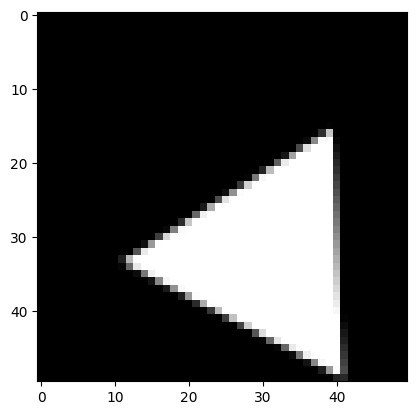

In [ ]:
first_image = X_train_tensor[4].squeeze()
plt.imshow(first_image.numpy(), cmap='gray')
plt.show()

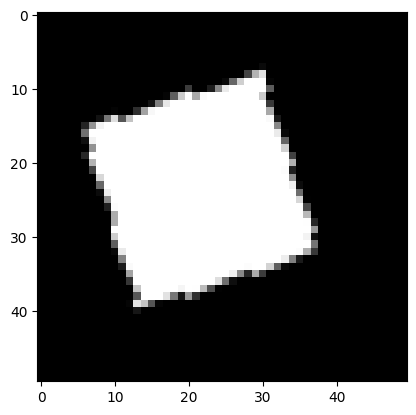

In [ ]:
first_image = X_train_tensor_new[2].squeeze()
plt.imshow(first_image.numpy(), cmap='gray')
plt.show()

In [13]:
# Create DataLoader objects for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [4]:
device = "cuda"  #'cpu'

In [5]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        # Dense layers
        self.fc1 = nn.Linear(16*12*12, 32)   # Adjusted for the output size after conv and pooling layers
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

snet = SmallNet().to(device)

# Loss function and optimizer
criterion_f = nn.CrossEntropyLoss()
optimizer_f = optim.Adadelta(snet.parameters())

In [ ]:
# Training loop
snet.train()
epochs = 20
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_f.zero_grad()
        outputs = snet(images)
        loss = criterion_f(outputs, labels)
        loss.backward()
        optimizer_f.step()

        running_loss += loss.item()
    losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 1.3696169418948037
Epoch 2, Loss: 1.2116289040872028
Epoch 3, Loss: 1.1369799017906188
Epoch 4, Loss: 1.102605909534863
Epoch 5, Loss: 1.0890633072171891
Epoch 6, Loss: 1.078010534601552
Epoch 7, Loss: 1.0728183814457484
Epoch 8, Loss: 1.0684121502297266
Epoch 9, Loss: 1.0675831654242107
Epoch 10, Loss: 1.065283238036292
Epoch 11, Loss: 1.0411753399031503
Epoch 12, Loss: 1.0012956830007689
Epoch 13, Loss: 0.9676940896681376
Epoch 14, Loss: 0.9511705719998904
Epoch 15, Loss: 0.9445754425866263
Epoch 16, Loss: 0.9416995365704809
Epoch 17, Loss: 0.9376165196299553
Epoch 18, Loss: 0.9378507541758674
Epoch 19, Loss: 0.9357237783925874
Epoch 20, Loss: 0.9350709770406995


In [6]:
#Loading in model from file uploaded in github
snet.load_state_dict(torch.load('cnn_model.pth'))

<ipython-input-6-ad9bfa36d16e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snet.load_state_dict(torch.load('cnn_model.pth'))


<All keys matched successfully>

In [14]:
# Calculating accuracy
snet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the train set: {accuracy:.2f}%')

Accuracy of the model on the test set: 98.43%
Accuracy of the model on the train set: 98.43%


In [15]:
# Importing test set
X_t, y_t= pickle.load(gzip.open("flatland_test.data", 'rb'))
X_t = X_t / 255
X_t_tensor = torch.tensor(X_t, dtype=torch.float32)
X_t_tensor = X_t_tensor.to(device)
X_t_tensor = X_t_tensor.unsqueeze(1)

Predicted Category: 3


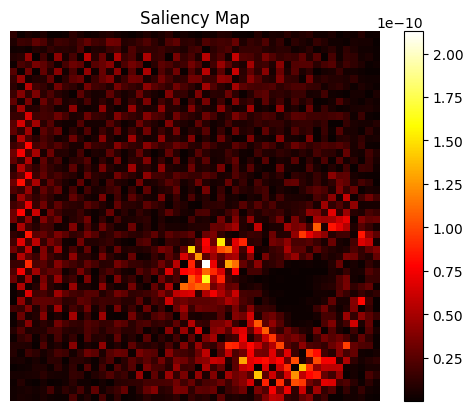

(-0.5, 49.5, 49.5, -0.5)

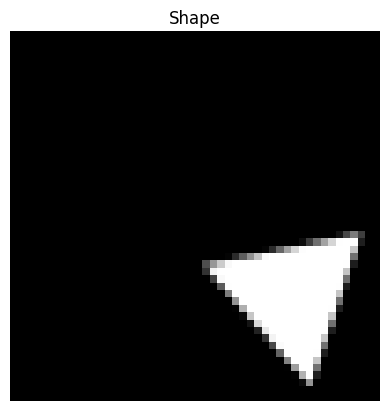

In [65]:
#Saliency
image = 7 #Select which image to plot

X = X_t_tensor[image].unsqueeze(0)
#X = X_train_tensor[image].unsqueeze(0)
#X = X.to(device)

X.requires_grad_()
output = snet(X)
class_idx = output.argmax(dim=1).item()
# Prints the prediction
predicted_category = class_idx + 2 if class_idx != 0 else 0
print("Predicted Category:", predicted_category)

# Compute gradients of the target class with respect to the input image
snet.zero_grad()
output[0, class_idx].backward()

# Get absolute values of the gradients and remove any extra dimensions
saliency, _ = torch.max(torch.abs(X.grad.data), dim=1)

# Get absolute values of the gradients and remove any extra dimensions
saliency = saliency.squeeze().cpu().numpy()
# Plot the saliency map

plt.imshow(saliency, cmap='hot')
plt.colorbar()
plt.title("Saliency Map")
plt.axis('off')
plt.show()

#Plot original image
plt.imshow(X.squeeze().cpu().detach().numpy(),cmap='gray')
plt.title("Shape")
plt.axis('off')

In [ ]:
# Test set eval
snet.eval()
with torch.no_grad():
  outputs = snet(X_t_tensor)
  _, predicted = torch.max(outputs, 1)

In [ ]:
# Printing out predictions as one string
predicted = predicted.cpu()
predicted_list = predicted.tolist()
predicted_list = [x + 2 if x != 0 else x for x in predicted_list]
predicted_string = ''.join(map(str, predicted_list))
print(predicted_string)

6645533343400063340545465645540453050355560333004353364366654054553303655503043350530654500355355463530403355345345040035360650004555530445455543654345046545635635636546303536656365660360305665463536336353336335465353306053566453360450054500063446060346543400453633455446546354503345300344553655053533306444555353443403030605300054655506334560544330054364500443044350645463346050306554305553645045355533336636330650644345554354535063644433563304055544504505345553050664300303444544504030306344006554333400506436544330334035643434343650403330363543435603556453440550543403430450555505303434536654355435035004453066464566036403330463455364406563043554443345350503053556650564533336350334356344353343060333043443433504546433334035630054450544503643600503355633556300555303033036463444460546453433660605604345455536403330035505464066564430553033365340544530633543635653364030035430440356534344063556033036433354560635036440504640055344340360630645656404363635646435404000565355305364603035300453665355504

In [ ]:
#Export model
torch.save(snet.state_dict(), 'cnn_model.pth')